In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

/Users/dhiss/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
train_dir = "/Users/dhiss/Downloads/TA/FIX/Split Dataset/train"
validation_dir = "/Users/dhiss/Downloads/TA/FIX/Split Dataset/validasi"

In [3]:
# Augmentasi Data untuk Pelatihan
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,        # Rotasi hingga 30 derajat
    width_shift_range=0.2,    # Perpindahan horizontal
    height_shift_range=0.2,   # Perpindahan vertikal
    shear_range=0.2,          # Shearing
    zoom_range=0.2,           # Zooming
    horizontal_flip=True,     # Flipping horizontal
    fill_mode="nearest"       # Penanganan piksel kosong
)

# Validasi tetap hanya di rescale
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [4]:
# Load data pelatihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

Found 2259 images belonging to 6 classes.


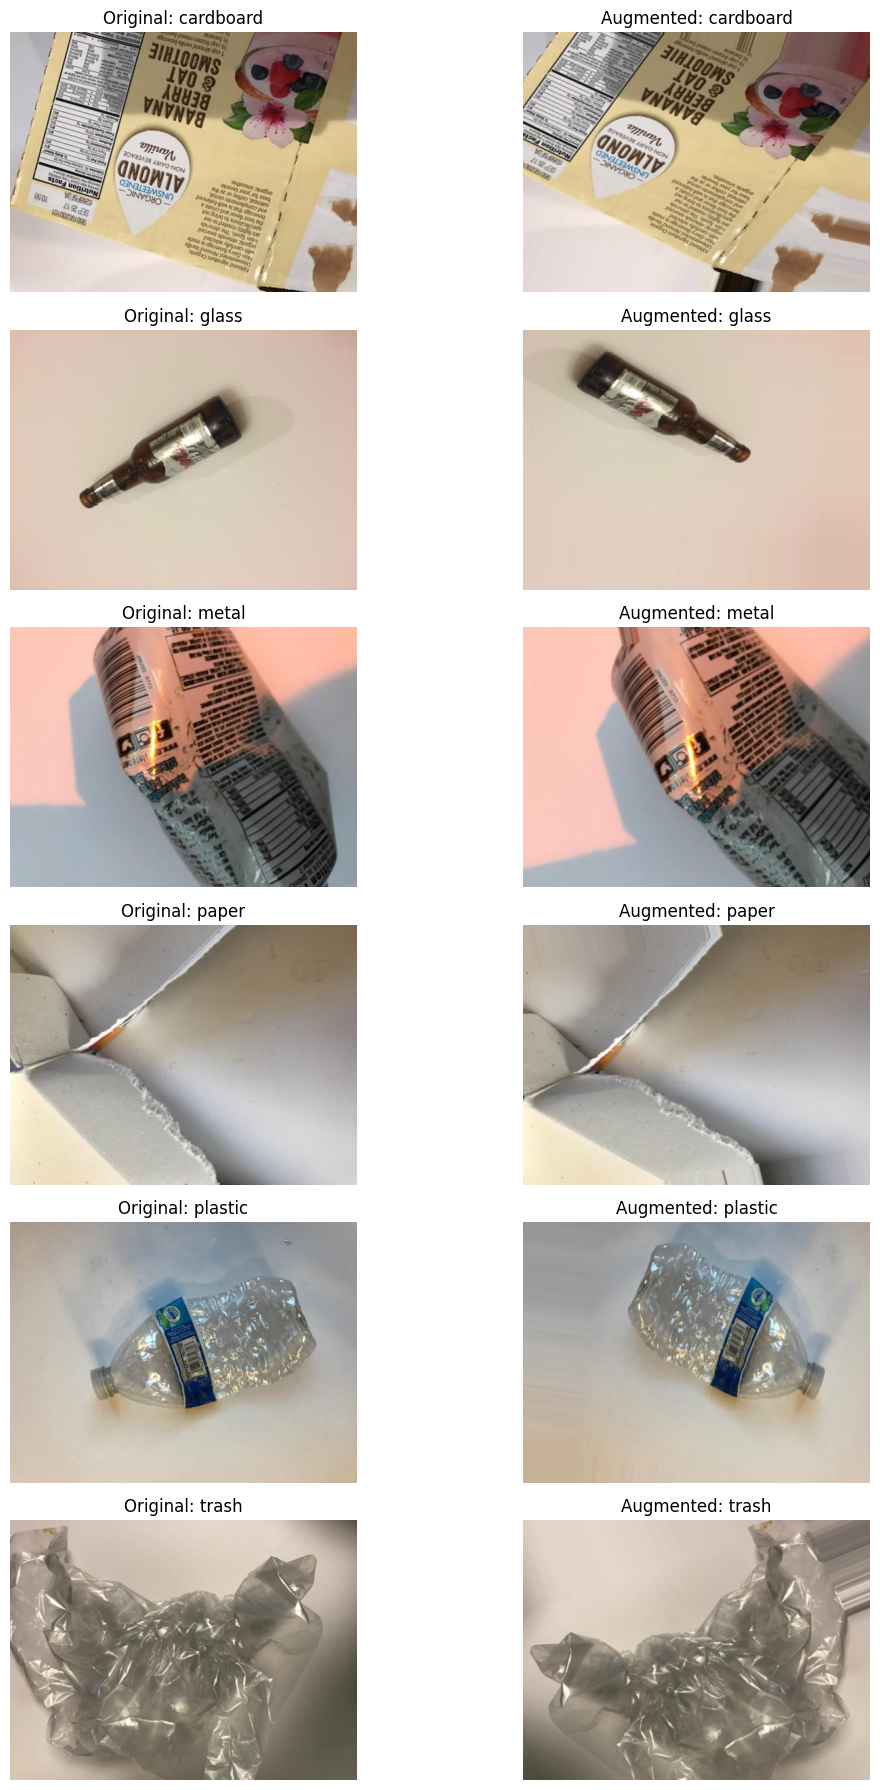

In [24]:
# Nama kelas
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Plot untuk menampilkan hasil
plt.figure(figsize=(12, 18))

for idx, class_name in enumerate(classes):
    # Ambil satu gambar dari setiap kelas
    class_dir = os.path.join(train_dir, class_name)
    image_path = os.path.join(class_dir, os.listdir(class_dir)[0])  # Gambar pertama di kelas tersebut
    
    # Load gambar
    original_image = load_img(image_path)  # PIL image
    original_image_array = img_to_array(original_image)  # Numpy array
    original_image_array = original_image_array[np.newaxis, ...]  # Tambahkan batch dimension
    
    # Generator augmentasi
    augmented_images = train_datagen.flow(original_image_array, batch_size=1)
    augmented_image = next(augmented_images)[0]  # Hasil augmentasi pertama
    
    # Tampilkan gambar asli
    plt.subplot(6, 2, idx * 2 + 1)
    plt.imshow(original_image)
    plt.title(f"Original: {class_name}")
    plt.axis("off")
    
    # Tampilkan hasil augmentasi
    plt.subplot(6, 2, idx * 2 + 2)
    plt.imshow(augmented_image)
    plt.title(f"Augmented: {class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
# Load data validasi
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

Found 898 images belonging to 6 classes.


In [6]:
base_model = VGG16(include_top=False, input_shape=(180, 180, 3), weights='imagenet')

model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),
    Dense(6, activation="softmax")
])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-12-27 17:14:46.548441: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-27 17:14:46.548467: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-27 17:14:46.548472: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-27 17:14:46.548487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-27 17:14:46.548498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,542,676 (169.92 MB)

 Trainable params: 14,847,558 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,695,118 (113.28 MB)

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Turunkan learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
filepath = '/Users/dhiss/Downloads/TA/FIX/model/Vgg16Aug.keras'

checkpoint = ModelCheckpoint(filepath,
        monitor = 'val_loss',
        save_best_only=True,
        verbose = 1)
callback_list = [checkpoint]

In [9]:
# Melatih model dan menyimpan history
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks = callback_list
)

/Users/dhiss/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


2024-12-27 17:14:48.467066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2136 - loss: 5.4827
Epoch 1: val_loss improved from inf to 4.75185, saving model to /Users/dhiss/Downloads/TA/FIX/model/Vgg16Aug.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.2140 - loss: 5.4760 - val_accuracy: 0.3374 - val_loss: 4.7518
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2556 - loss: 4.8946
Epoch 2: val_loss improved from 4.75185 to 4.37366, saving model to /Users/dhiss/Downloads/TA/FIX/model/Vgg16Aug.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.2567 - loss: 4.8916 - val_accuracy: 0.3742 - val_loss: 4.3737
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3890 - loss: 4.4393
Epoch 3: val_loss improved from 4.37366 to 3.84025, saving model to /Users/dhiss/Downloads/TA/FIX/model/Vgg16Aug.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.3904 - loss: 4.4353 - val_accuracy: 0.5122 - val_loss: 3.8402
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 

In [ ]:
# Plotting accuracy and loss side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plotting accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Akurasi Model VGG16')
ax1.set_ylabel('Akurasi')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss Model VGG16')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

Found 487 images belonging to 6 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.9669 - loss: 0.3948
Loss: 0.37151139974594116
Accuracy: 0.9671458005905151
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 543ms/step

Metrics using sklearn:
Accuracy: 0.9671457905544147
Precision: 0.9682883434117995
Recall: 0.9671457905544147
F1 Score: 0.967070705946117

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.99      0.99      0.99        77
       glass       0.98      0.92      0.95        95
       metal       0.91      1.00      0.95        77
       paper       0.98      1.00      0.99       112
     plastic       0.97      0.94      0.95        96
       trash       1.00      0.97      0.98        30

    accuracy                           0.97       487
   macro avg       0.97      0.97      0.97       487
weighted avg       0.97      0.97      0.97       487



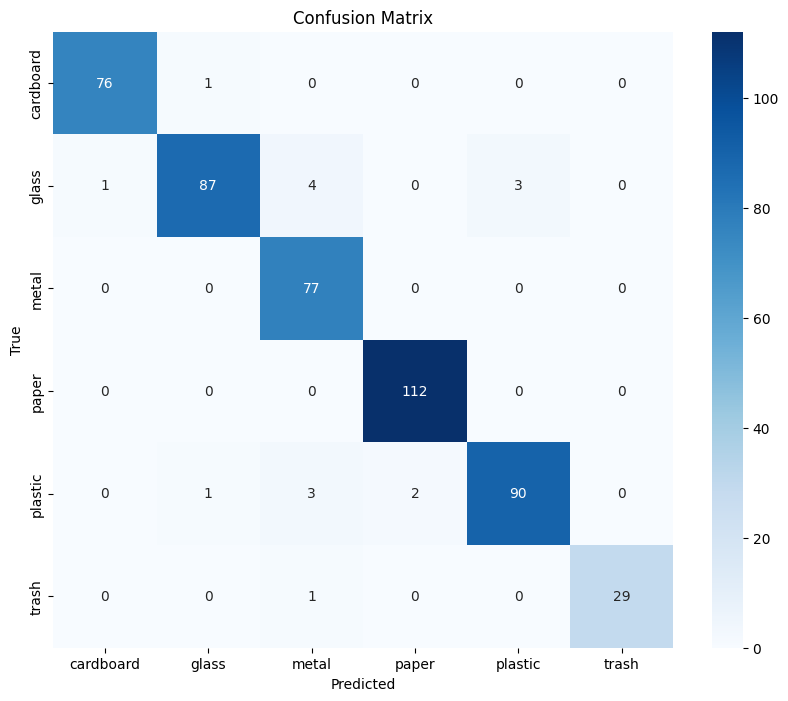

In [11]:
# Path ke model yang disimpan
model_path = '/Users/dhiss/Downloads/TA/FIX/model/Vgg16Aug.keras'

# Memuat model
model = load_model(model_path)

# Path ke direktori dataset
test_dir = "/Users/dhiss/Downloads/TA/FIX/Split Dataset/uji"

# Membuat objek ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load data uji
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # Pastikan shuffle dinonaktifkan untuk menjaga urutan data
)

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(test_generator)

# Selesai menghitung waktu
end_time = time.perf_counter()

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Menghitung prediksi untuk data uji
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Mendapatkan label sebenarnya dari test_generator
y_true = test_generator.classes

# Mendapatkan label class dari test_generator
class_labels = list(test_generator.class_indices.keys())

# Menghitung metrik menggunakan sklearn
accuracy_sklearn = accuracy_score(y_true, y_pred)
precision_sklearn = precision_score(y_true, y_pred, average='weighted')
recall_sklearn = recall_score(y_true, y_pred, average='weighted')
f1_sklearn = f1_score(y_true, y_pred, average='weighted')

print("\nMetrics using sklearn:")
print(f"Accuracy: {accuracy_sklearn}")
print(f"Precision: {precision_sklearn}")
print(f"Recall: {recall_sklearn}")
print(f"F1 Score: {f1_sklearn}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
